In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

import pickle

from modal.BigModal import SubToSeq
from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, Timer, Average
from dataset.readVideo import DramaDataset
useCuda = True
Variable = Variable.cuda if useCuda else Variable

In [2]:
import torch.utils.data
DataDir = "/home/ball/Videos/Broke"
datasets = DramaDataset(basedir=DataDir,
                    maxFrame=0,
                    )
loader = torch.utils.data.DataLoader(datasets, batch_size=5, shuffle=True, num_workers=2)

In [16]:
ModalFile = "SubToSub/modals/layer1/"
modal = torch.load(ModalFile+"SubSubModal.10.pth")
with open(ModalFile+"Lang.pkl", 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModalFile, len(lang)))

Load lang model: SubToSub/modals/layer1/. Word size: 2579


In [4]:
subencoderOpt = {
    "word_size": len(lang),
    "em_size": 256,
    "hidden_size": 256,
    "num_layers": 2,
    "output_size": 512 
}
decoderOpt = {
    "word_size": len(lang),
    "em_size": 256,
    "hidden_size": 26,
    "num_layers": 2,
    "feature_size": 512 
}
modal = SubToSeq(subencoderOpt, decoderOpt).cuda()

In [6]:
def transData(in_sents, target_sents, lang):
    in_seqs = []
    in_targets = []
    out_targets = []
    
    vectorTransforms = [torch.LongTensor, Variable]
    
    for sent in in_sents:
        in_seqs.append(lang.sentenceToVector(sent, sos=False, eos=False))
    in_seqs = padding(in_seqs, lang["PAD"], vectorTransforms)
    
    for sent in target_sents:
        in_targets.append(lang.sentenceToVector(sent, sos=True, eos=False))
        out_targets.append(lang.sentenceToVector(sent, sos=False, eos=True))
    in_targets = padding(in_targets, lang["PAD"], vectorTransforms)
    out_targets = padding(out_targets, lang["PAD"], vectorTransforms)
    return in_seqs, in_targets, out_targets

In [7]:
def predit(modal, lang, in_sents, max_length=50):
    ans = []
    probs = []
    in_seq = Variable(torch.LongTensor(lang.sentenceToVector(in_sents, sos=False, eos=False)).unsqueeze(0))
    inputs = Variable(torch.LongTensor([[lang["SOS"]]]).long())
    hidden = None
    
    cxt = modal.makeContext(in_seq)
    for i in range(max_length):
        outputs, hidden = modal.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        outputs = outputs[0][0].data[0]
        if(outputs == lang["EOS"]):
            break
        probs.append(prob)
        ans.append(outputs)
        inputs = Variable(torch.LongTensor([[outputs]]))
    return lang.vectorToSentence(ans), probs

In [8]:
import matplotlib.pyplot as plt
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()

In [9]:
it = iter(loader)

In [20]:
pres, nexs, imgs = it.next()

In [21]:
modal.eval()
for pre, nex in zip(pres, nexs):
    pred = predit(modal, lang, pre)
    print("Pre  : {}\nNext : {}\nModal: {}\n\n".format(pre, nex, pred[0]))

Pre  : 當朋友陷於油惠券狂熱之中時
Next : 她爲了一盒特別的蛋糕粉 堅守底線
Modal: 我們去了白車了


Pre  : 但我媽總說不要用心
Next : 只有頭腦才能做音樂
Modal: 我們去來了一克力了


Pre  : i 306度天堂 培根 i
Next : 看看這書名 306度天堂 培根
Modal: 看看看該這個嗎這個


Pre  : 是誰呀
Next : 我是Caroline 住對門
Modal: 我 Soline 是Caroline Caroline Caroline Caroline Caro


Pre  : 有時 我找個瓶子幫自己度過難關
Next : 或着找根針 或是找個女的
Modal: 是那個的時候 這個兒




In [12]:
in_seq = Variable(torch.LongTensor(lang.sentenceToVector(pres[1], sos=False, eos=False)).unsqueeze(0))
inputs = Variable(torch.LongTensor([[lang["SOS"]]]).long())
hidden = None

cxt = modal.makeContext(in_seq)

In [13]:
outputs, hidden = modal.decode(inputs, cxt, hidden)

In [14]:
outputs.topk(3)

(Variable containing:
 (0 ,.,.) = 
   0.1233  0.0689  0.0528
 [torch.cuda.FloatTensor of size 1x1x3 (GPU 0)], Variable containing:
 (0 ,.,.) = 
   11  13  31
 [torch.cuda.LongTensor of size 1x1x3 (GPU 0)])

In [15]:
cxt.topk(3)

(Variable containing:
  1.1281  1.0775  1.0400
 [torch.cuda.FloatTensor of size 1x3 (GPU 0)], Variable containing:
  466   23   94
 [torch.cuda.LongTensor of size 1x3 (GPU 0)])

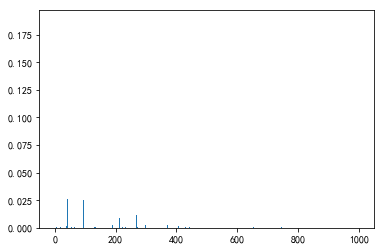

In [63]:
showVar(outputs[0,0,:1000])

In [18]:
prob, outputs = outputs.data.topk(5)
print(prob, outputs)


(0 ,.,.) = 
1.00000e-05 *
   9.0651  8.3885  8.3885  8.3885  8.3885
[torch.cuda.FloatTensor of size 1x1x5 (GPU 0)]
 
(0 ,.,.) = 
  243    2    0    3    1
[torch.cuda.LongTensor of size 1x1x5 (GPU 0)]



In [13]:
inputs = Variable(torch.LongTensor([[outputs[0,0][1]]]))
outputs, hidden = modal.decode(inputs, cxt, hidden)

In [14]:
prob, outputs = outputs.data.topk(5)
print(prob, outputs)


(0 ,.,.) = 
1.00000e-04 *
   2.4216  1.0642  0.8387  0.8387  0.8387
[torch.cuda.FloatTensor of size 1x1x5 (GPU 0)]
 
(0 ,.,.) = 
   4891  10552      2      1      0
[torch.cuda.LongTensor of size 1x1x5 (GPU 0)]



In [131]:
lang[11]

'夥計'

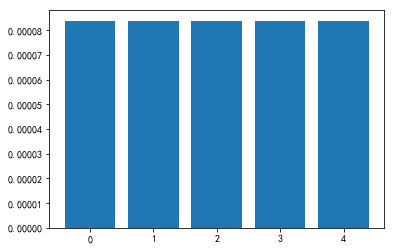

In [56]:
showVar(outputs.topk(5)[0][0,0,:])

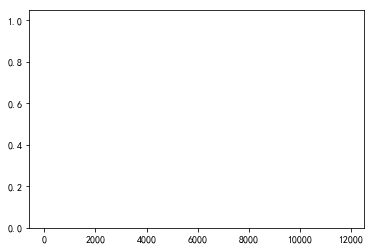

In [45]:
showVar(outputs[0][0])

In [50]:
lang[1107]

'嘿'